#### Data: https://www.kaggle.com/datasets/hasibhaque/football-match-semantic-segmentation

In [1]:
import pandas as pd
import torch
from torchvision import datasets, transforms
import torch.nn as nn
from torchsummary import summary
import torch.nn.functional as F
from torch import optim
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from glob import glob

In [2]:
class SegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, size= 256):
        self.img_dir = glob(img_dir+'/*.png')
        self.mask_dir = glob(mask_dir+'/*.png')
        self.labels = np.array([[237,34,236],[201,158,74],[96,32,192],[89,134,179],[153,223,219],[255,106,77],[22,100,252],[143,183,45],[38,198,129],[27,154,218],[0,0,0]])
        self.size = size
    def __len__(self):
        return len(self.img_dir)
        
    def rgb_to_class(self,mask_rgb, color_map):
        """
        Convert an RGB mask to a 2D mask of class indices using vectorized NumPy operations.
        mask_rgb: HxWx3 array (RGB)
        color_map: Nx3 array of class colors
        """
        h, w, _ = mask_rgb.shape
        mask_flat = mask_rgb.reshape(-1, 3)
    
        matches = np.all(mask_flat[:, None, :] == color_map[None, :, :], axis=2)
        mask_indices = np.argmax(matches, axis=1).astype(np.uint8)
    
        return mask_indices.reshape(h, w)
    def __getitem__(self, idx):
        img = cv2.imread(self.img_dir[idx])
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_dir[idx])
        mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
        img_resize = cv2.resize(img,(self.size,self.size))
        # mask_resize = cv2.resize(mask,(self.size,self.size))
        mask_resize = cv2.resize(mask, (self.size, self.size), interpolation=cv2.INTER_NEAREST)
        
        target = self.rgb_to_class(mask_resize,self.labels)
        
        img = torch.from_numpy(img_resize).permute(2, 0, 1).float() / 255.0  # (C, H, W)
        target = torch.from_numpy(target).long()  # mask as integer labels
        
    
        return img, target
        

In [3]:
temp = SegmentationDataset('data_segments/train/images/','data_segments/train/masks//')

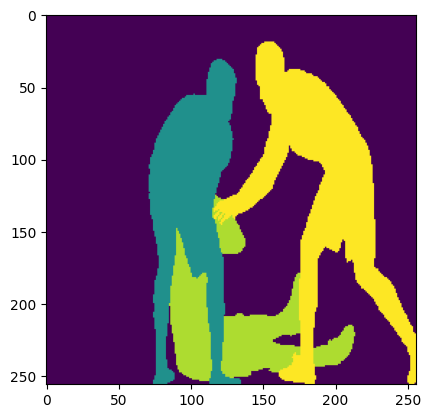

In [4]:
plt.imshow(temp[1][1])

I use this Architurecture For my FCN8s, For Kernel, Strinde, Padding it not include in this images so I decide to use base on my decision.

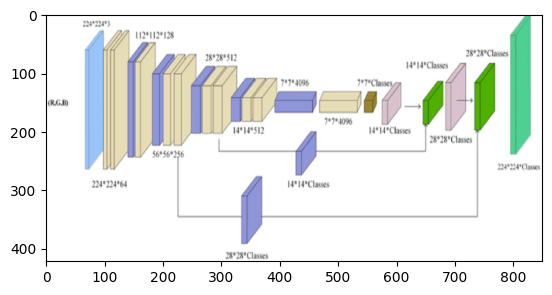

In [30]:
plt.imshow(cv2.imread('Fcn8s-model.png'))

## This Model I make Unit smaller because I need it more faster

In [5]:
class FCN8s(nn.Module):
    def __init__(self,c_in,c_out,unit= [8,16,32,64,512]):
        super().__init__()
        ######### Down Sampling
        self.block1 = nn.Sequential(
            nn.Conv2d(c_in,unit[0],kernel_size=5,stride=2,padding=2,bias=False),
            nn.Conv2d(unit[0],unit[0],kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(unit[0]),
            nn.ReLU(),
            nn.Conv2d(unit[0],unit[1],kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(unit[1]),
            nn.ReLU(),  
        )
        self.block2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(unit[1],unit[1],kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(unit[1]),
            nn.ReLU(),  
            nn.Conv2d(unit[1],unit[2],kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(unit[2]),
            nn.ReLU(),  
        )
        self.block3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(unit[2],unit[2],kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(unit[2]),
            nn.ReLU(),  
            nn.Conv2d(unit[2],unit[2],kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(unit[2]),
            nn.ReLU(),  
            nn.Conv2d(unit[2],unit[3],kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(unit[3]),
            nn.ReLU(),  
        )
        self.block4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(unit[3],unit[3],kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(unit[3]),
            nn.ReLU(),  
            nn.Conv2d(unit[3],unit[3],kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(unit[3]),
            nn.ReLU(),  
            nn.Conv2d(unit[3],unit[3],kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(unit[3]),
            nn.ReLU(),  
        )
        self.block5 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(unit[3],unit[3],kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(unit[3]),
            nn.ReLU(),  
            nn.Conv2d(unit[3],unit[3],kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(unit[3]),
            nn.ReLU(), 
            nn.Conv2d(unit[3],unit[4],kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(unit[4]),
            nn.ReLU(), 
        )
        self.block6 = nn.Sequential( 
            nn.Conv2d(unit[4],unit[4],kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(unit[4]),
            nn.ReLU(),  
            nn.Conv2d(unit[4],c_out,kernel_size=1,stride=1,bias=False),
        )
        ######## Up Sampling 
        self.block7 = nn.Sequential(
            nn.ConvTranspose2d(c_out,c_out,kernel_size=4,stride=2,padding=1,output_padding=0,bias=False),
            nn.BatchNorm2d(c_out),
            nn.ReLU(),  
        )
        self.block8 = nn.Sequential(
            nn.ConvTranspose2d(c_out,c_out,kernel_size=4,stride=2,padding=1,output_padding=0,bias=False),
            nn.BatchNorm2d(c_out),
            nn.ReLU(),  
        )

        self.block9 = nn.Sequential(
            nn.ConvTranspose2d(c_out,c_out, kernel_size=8, stride=8, padding=0,bias=False),
            nn.Conv2d(c_out,c_out,kernel_size=1,stride=1,bias=False),
        )

        self.skipblock1 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(unit[2],c_out,kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(c_out),
            nn.ReLU(), 
        )
        self.skipblock2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(unit[3],c_out,kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(c_out),
            nn.ReLU(), 
        )
        
    def forward(self,x):
        x = self.block1(x)
        x = self.block2(x)
        skip1 = self.skipblock1(x)
        x = self.block3(x)
        skip2 = self.skipblock2(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x) + skip2
        x = self.block8(x) + skip1
        x = self.block9(x)
        return x

In [6]:
summary(FCN8s(3,11).to('cuda'),(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 128, 128]             600
            Conv2d-2          [-1, 8, 128, 128]             576
       BatchNorm2d-3          [-1, 8, 128, 128]              16
              ReLU-4          [-1, 8, 128, 128]               0
            Conv2d-5         [-1, 16, 128, 128]           1,152
       BatchNorm2d-6         [-1, 16, 128, 128]              32
              ReLU-7         [-1, 16, 128, 128]               0
         MaxPool2d-8           [-1, 16, 64, 64]               0
            Conv2d-9           [-1, 16, 64, 64]           2,304
      BatchNorm2d-10           [-1, 16, 64, 64]              32
             ReLU-11           [-1, 16, 64, 64]               0
           Conv2d-12           [-1, 32, 64, 64]           4,608
      BatchNorm2d-13           [-1, 32, 64, 64]              64
             ReLU-14           [-1, 32,

In [7]:
train_dataset = SegmentationDataset('data_segments/train/images/','data_segments/train/masks//')
test_dataset = SegmentationDataset('data_segments/test/images/','data_segments/test/masks//')

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

In [8]:
device = 'cuda:3'

## First Experiment: FCN8s + Original BackBone + Adam 

In [20]:
# --- START FIX: Corrected and Improved Training Loop ---
model = FCN8s(3,11).to(device)

epochs = 80 
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# FIX 2: Add a learning rate scheduler
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1, verbose=True)

loss_lst = []
val_loss_lst = [] # Track validation loss

for epoch in range(1, epochs + 1):
    total_loss = 0
    model.train() # Set model to training mode
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        
        pred = model(x)
        loss = loss_fn(pred,y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # FIX 3: Correct average loss calculation
    epoch_loss = total_loss / len(train_loader)
    loss_lst.append(epoch_loss)
    
    # --- Calculate Validation Loss (Good practice and needed for scheduler) ---
    model.eval() # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for x_val, y_val in test_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            val_pred = model(x_val)
            val_loss = loss_fn(val_pred, y_val)
            total_val_loss += val_loss.item()
            
    epoch_val_loss = total_val_loss / len(test_loader)
    val_loss_lst.append(epoch_val_loss)
    
    # Print both losses
    print(f"Epoch [{epoch}/{epochs}] Train Loss: {epoch_loss:.4f}  Val Loss: {epoch_val_loss:.4f}")
    
    # Step the scheduler based on validation loss
    # scheduler.step(epoch_val_loss)

# Save the new, improved model
torch.save(model.state_dict(), "FCN8s_fixed.pth")
# --- END FIX ---

Epoch [1/80] Train Loss: 2.3582  Val Loss: 2.3395
Epoch [2/80] Train Loss: 2.2158  Val Loss: 2.0995
Epoch [3/80] Train Loss: 2.0177  Val Loss: 1.8187
Epoch [4/80] Train Loss: 1.7892  Val Loss: 1.6134
Epoch [5/80] Train Loss: 1.5471  Val Loss: 1.4804
Epoch [6/80] Train Loss: 1.3362  Val Loss: 1.3962
Epoch [7/80] Train Loss: 1.1638  Val Loss: 1.1747
Epoch [8/80] Train Loss: 1.0643  Val Loss: 1.1338
Epoch [9/80] Train Loss: 0.9399  Val Loss: 0.8891
Epoch [10/80] Train Loss: 0.8649  Val Loss: 0.8607
Epoch [11/80] Train Loss: 0.8169  Val Loss: 0.6233
Epoch [12/80] Train Loss: 0.7291  Val Loss: 0.6316
Epoch [13/80] Train Loss: 0.6717  Val Loss: 0.6944
Epoch [14/80] Train Loss: 0.6437  Val Loss: 0.5541
Epoch [15/80] Train Loss: 0.6218  Val Loss: 0.6478
Epoch [16/80] Train Loss: 0.5828  Val Loss: 0.6156
Epoch [17/80] Train Loss: 0.5682  Val Loss: 0.5671
Epoch [18/80] Train Loss: 0.5716  Val Loss: 0.5189
Epoch [19/80] Train Loss: 0.5436  Val Loss: 0.5028
Epoch [20/80] Train Loss: 0.5349  Val Lo

In [9]:
def segmentation_metrics(preds, targets, num_classes):

    preds = torch.argmax(preds, dim=1)  # (1, H, W)
    preds = preds.squeeze(0)
    targets = targets.squeeze(0)

    iou_list = []

    for cls in range(num_classes):
        pred_mask = (preds == cls)
        true_mask = (targets == cls)

        intersection = (pred_mask & true_mask).sum().item()
        union = (pred_mask | true_mask).sum().item()

        if union == 0:
            continue

        iou = intersection / union
        iou_list.append(iou)

    mean_iou = sum(iou_list) / len(iou_list) if iou_list else 0.0
    pixel_acc = (preds == targets).sum().item() / torch.numel(targets)

    return mean_iou, pixel_acc

In [22]:
num_classes = 11  # number of segmentation classes

total_miou, total_acc, count = 0, 0, 0

model.eval()
with torch.no_grad():
    for image, label in test_loader:
        image, label = image.to(device), label.to(device)
        output = model(image)
        preds = torch.argmax(output, dim=1)

        miou, acc = segmentation_metrics(output, label, num_classes=11)
        # print(f"Mean IoU: {miou:.4f}, Pixel Accuracy: {acc:.4f}")
        total_miou += miou
        total_acc += acc
        count += 1
    print(total_miou / count, total_acc / count)


0.44091811605901154 0.9265449523925782


In [23]:
output.shape

torch.Size([1, 11, 256, 256])

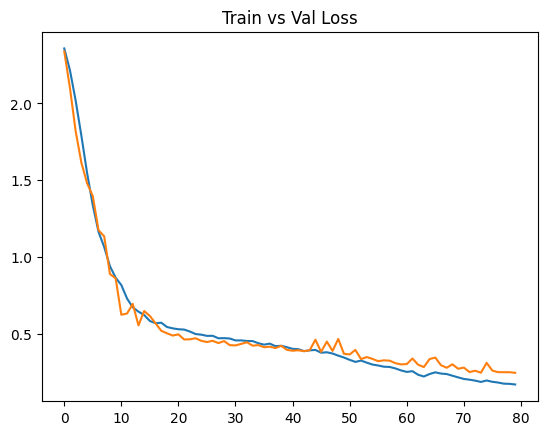

In [28]:
plt.title('Train vs Val Loss')
plt.plot(loss_lst)
plt.plot(val_loss_lst)

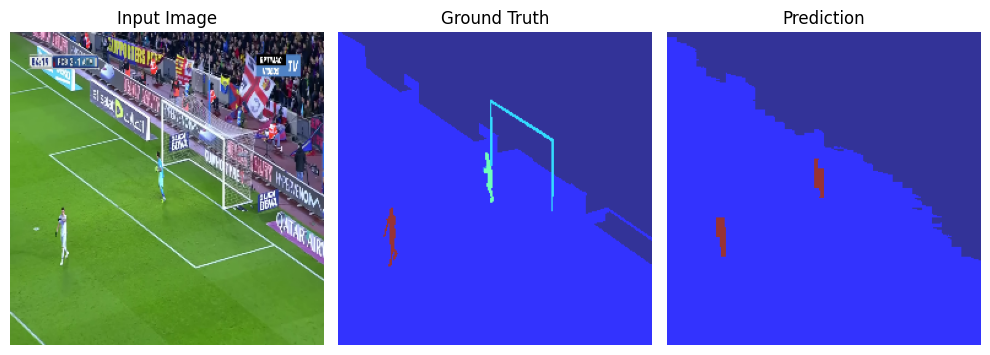

In [32]:
images, masks = next(iter(test_loader))
images, masks = images.to(device), masks.to(device)

# Predict
model.eval()
with torch.no_grad():
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)

# Move to CPU for visualization
images = images.cpu()
masks = masks.cpu()
preds = preds.cpu()
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Original image
axs[0].imshow(images.squeeze().permute(1, 2, 0), cmap='gray')
axs[0].set_title('Input Image')
axs[0].axis('off')

# Ground truth mask
axs[1].imshow(masks.squeeze(), cmap='jet', alpha=0.8)
axs[1].set_title('Ground Truth')
axs[1].axis('off')

# Predicted mask
axs[2].imshow(preds[0], cmap='jet', alpha=0.8)
axs[2].set_title('Prediction')
axs[2].axis('off')

plt.tight_layout()
plt.show()

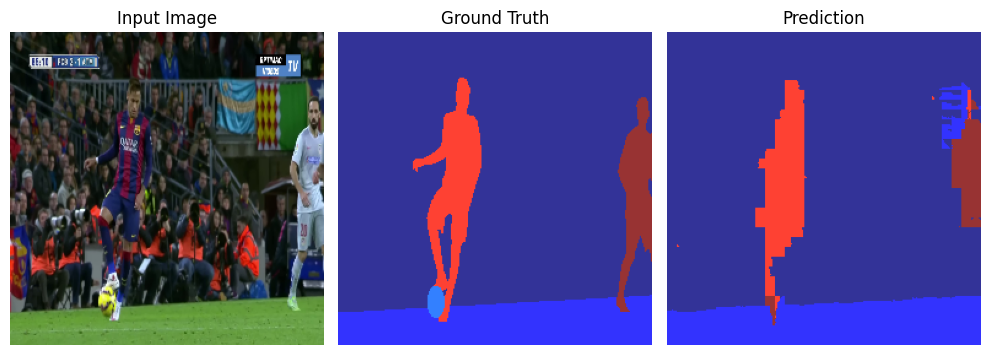

In [33]:
images, masks = next(iter(test_loader))
images, masks = images.to(device), masks.to(device)

# Predict
model.eval()
with torch.no_grad():
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)

# Move to CPU for visualization
images = images.cpu()
masks = masks.cpu()
preds = preds.cpu()
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Original image
axs[0].imshow(images.squeeze().permute(1, 2, 0), cmap='gray')
axs[0].set_title('Input Image')
axs[0].axis('off')

# Ground truth mask
axs[1].imshow(masks.squeeze(), cmap='jet', alpha=0.8)
axs[1].set_title('Ground Truth')
axs[1].axis('off')

# Predicted mask
axs[2].imshow(preds[0], cmap='jet', alpha=0.8)
axs[2].set_title('Prediction')
axs[2].axis('off')

plt.tight_layout()
plt.show()

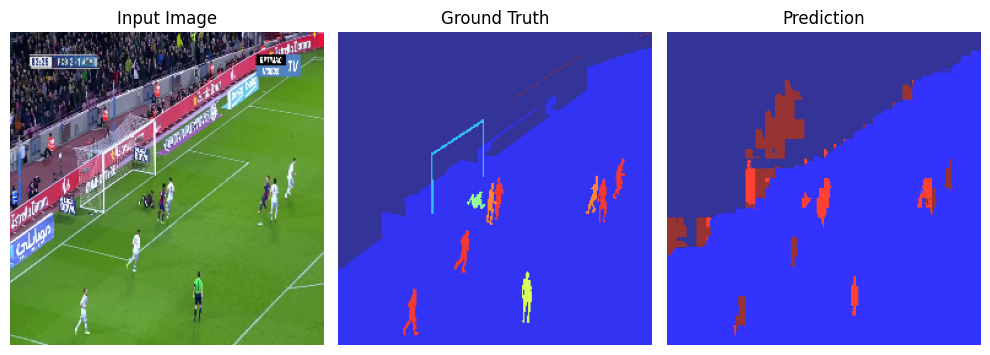

In [34]:
images, masks = next(iter(test_loader))
images, masks = images.to(device), masks.to(device)

# Predict
model.eval()
with torch.no_grad():
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)

# Move to CPU for visualization
images = images.cpu()
masks = masks.cpu()
preds = preds.cpu()
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Original image
axs[0].imshow(images.squeeze().permute(1, 2, 0), cmap='gray')
axs[0].set_title('Input Image')
axs[0].axis('off')

# Ground truth mask
axs[1].imshow(masks.squeeze(), cmap='jet', alpha=0.8)
axs[1].set_title('Ground Truth')
axs[1].axis('off')

# Predicted mask
axs[2].imshow(preds[0], cmap='jet', alpha=0.8)
axs[2].set_title('Prediction')
axs[2].axis('off')

plt.tight_layout()
plt.show()

## First Experiment: FCN8s + Original BackBone + SGD

In [9]:
model = FCN8s(3,11).to(device)

epochs = 100 
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)

loss_lst = []
val_loss_lst = [] # Track validation loss

for epoch in range(1, epochs + 1):
    total_loss = 0
    model.train() # Set model to training mode
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        
        pred = model(x)
        loss = loss_fn(pred,y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # FIX 3: Correct average loss calculation
    epoch_loss = total_loss / len(train_loader)
    loss_lst.append(epoch_loss)
    
    # --- Calculate Validation Loss (Good practice and needed for scheduler) ---
    model.eval() # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for x_val, y_val in test_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            val_pred = model(x_val)
            val_loss = loss_fn(val_pred, y_val)
            total_val_loss += val_loss.item()
            
    epoch_val_loss = total_val_loss / len(test_loader)
    val_loss_lst.append(epoch_val_loss)
    
    # Print both losses
    print(f"Epoch [{epoch}/{epochs}] Train Loss: {epoch_loss:.4f}  Val Loss: {epoch_val_loss:.4f}")
    
    # Step the scheduler based on validation loss
    # scheduler.step(epoch_val_loss)

# Save the new, improved model
torch.save(model.state_dict(), "FCN8s_SGD.pth")
# --- END FIX ---

Epoch [1/100] Train Loss: 2.3987  Val Loss: 2.3988
Epoch [2/100] Train Loss: 2.3978  Val Loss: 2.3989
Epoch [3/100] Train Loss: 2.3968  Val Loss: 2.3979
Epoch [4/100] Train Loss: 2.3959  Val Loss: 2.3964
Epoch [5/100] Train Loss: 2.3950  Val Loss: 2.3950
Epoch [6/100] Train Loss: 2.3939  Val Loss: 2.3938
Epoch [7/100] Train Loss: 2.3930  Val Loss: 2.3925
Epoch [8/100] Train Loss: 2.3921  Val Loss: 2.3913
Epoch [9/100] Train Loss: 2.3909  Val Loss: 2.3901
Epoch [10/100] Train Loss: 2.3901  Val Loss: 2.3890
Epoch [11/100] Train Loss: 2.3888  Val Loss: 2.3879
Epoch [12/100] Train Loss: 2.3879  Val Loss: 2.3868
Epoch [13/100] Train Loss: 2.3867  Val Loss: 2.3857
Epoch [14/100] Train Loss: 2.3859  Val Loss: 2.3845
Epoch [15/100] Train Loss: 2.3844  Val Loss: 2.3833
Epoch [16/100] Train Loss: 2.3832  Val Loss: 2.3820
Epoch [17/100] Train Loss: 2.3821  Val Loss: 2.3808
Epoch [18/100] Train Loss: 2.3811  Val Loss: 2.3794
Epoch [19/100] Train Loss: 2.3793  Val Loss: 2.3781
Epoch [20/100] Train 

In [10]:
num_classes = 11  # number of segmentation classes

total_miou, total_acc, count = 0, 0, 0

model.eval()
with torch.no_grad():
    for image, label in test_loader:
        image, label = image.to(device), label.to(device)
        output = model(image)
        preds = torch.argmax(output, dim=1)

        miou, acc = segmentation_metrics(output, label, num_classes=11)
        # print(f"Mean IoU: {miou:.4f}, Pixel Accuracy: {acc:.4f}")
        total_miou += miou
        total_acc += acc
        count += 1
    print(total_miou / count, total_acc / count)


0.15812896597655338 0.6760200500488281


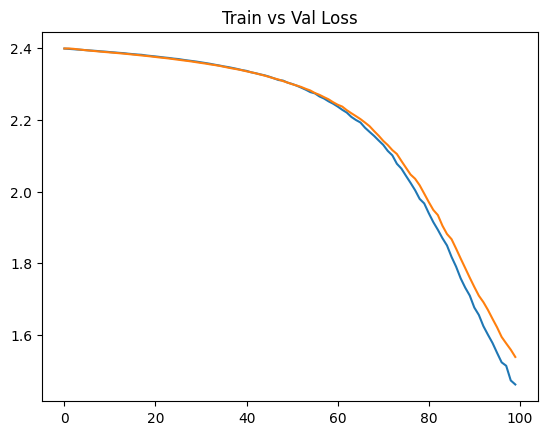

In [11]:
plt.title('Train vs Val Loss')
plt.plot(loss_lst)
plt.plot(val_loss_lst)

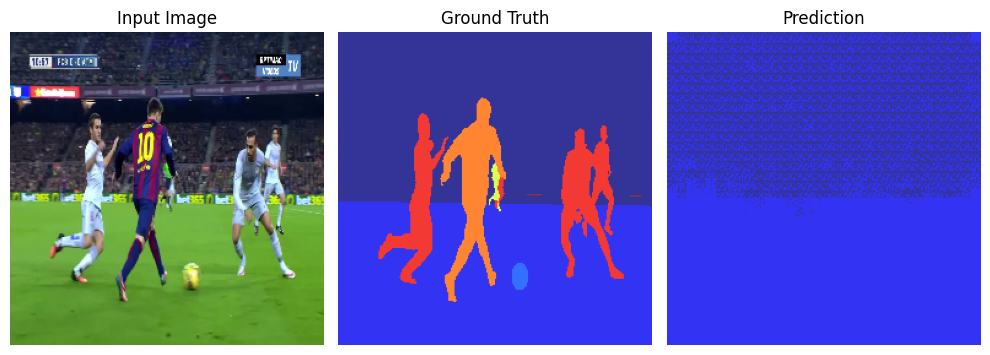

In [12]:
images, masks = next(iter(test_loader))
images, masks = images.to(device), masks.to(device)

# Predict
model.eval()
with torch.no_grad():
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)

# Move to CPU for visualization
images = images.cpu()
masks = masks.cpu()
preds = preds.cpu()
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Original image
axs[0].imshow(images.squeeze().permute(1, 2, 0), cmap='gray')
axs[0].set_title('Input Image')
axs[0].axis('off')

# Ground truth mask
axs[1].imshow(masks.squeeze(), cmap='jet', alpha=0.8)
axs[1].set_title('Ground Truth')
axs[1].axis('off')

# Predicted mask
axs[2].imshow(preds[0], cmap='jet', alpha=0.8)
axs[2].set_title('Prediction')
axs[2].axis('off')

plt.tight_layout()
plt.show()

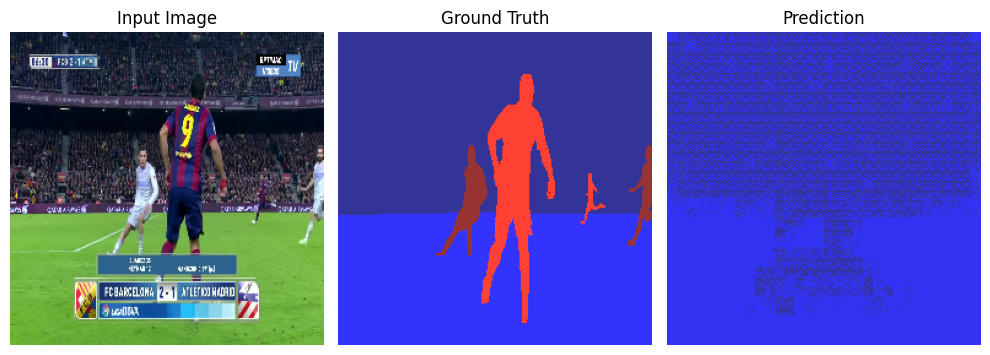

In [13]:
images, masks = next(iter(test_loader))
images, masks = images.to(device), masks.to(device)

# Predict
model.eval()
with torch.no_grad():
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)

# Move to CPU for visualization
images = images.cpu()
masks = masks.cpu()
preds = preds.cpu()
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Original image
axs[0].imshow(images.squeeze().permute(1, 2, 0), cmap='gray')
axs[0].set_title('Input Image')
axs[0].axis('off')

# Ground truth mask
axs[1].imshow(masks.squeeze(), cmap='jet', alpha=0.8)
axs[1].set_title('Ground Truth')
axs[1].axis('off')

# Predicted mask
axs[2].imshow(preds[0], cmap='jet', alpha=0.8)
axs[2].set_title('Prediction')
axs[2].axis('off')

plt.tight_layout()
plt.show()

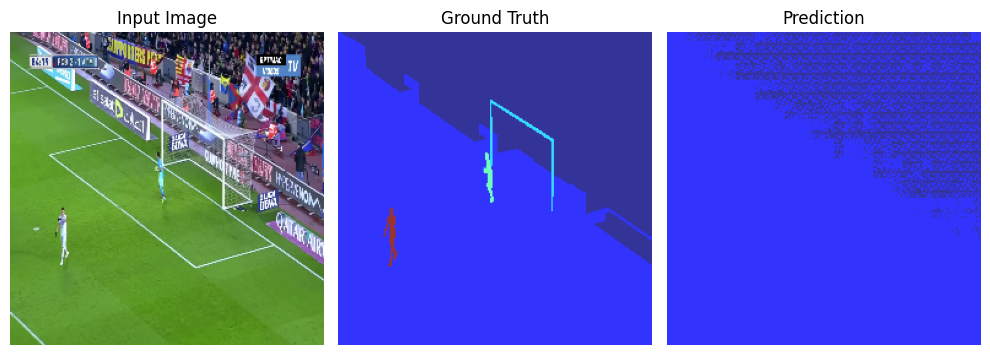

In [14]:
images, masks = next(iter(test_loader))
images, masks = images.to(device), masks.to(device)

# Predict
model.eval()
with torch.no_grad():
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)

# Move to CPU for visualization
images = images.cpu()
masks = masks.cpu()
preds = preds.cpu()
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Original image
axs[0].imshow(images.squeeze().permute(1, 2, 0), cmap='gray')
axs[0].set_title('Input Image')
axs[0].axis('off')

# Ground truth mask
axs[1].imshow(masks.squeeze(), cmap='jet', alpha=0.8)
axs[1].set_title('Ground Truth')
axs[1].axis('off')

# Predicted mask
axs[2].imshow(preds[0], cmap='jet', alpha=0.8)
axs[2].set_title('Prediction')
axs[2].axis('off')

plt.tight_layout()
plt.show()

#### Prediction so bad because it underfitting 

In [16]:
class FCN8s_bilinear(nn.Module):
    def __init__(self, c_in, c_out, unit=[4, 8, 16, 32, 256]):
        super().__init__()
        ######### Down Sampling
        self.block1 = nn.Sequential(
            nn.Conv2d(c_in, unit[0], kernel_size=5, stride=2, padding=2, bias=False),
            nn.Conv2d(unit[0], unit[0], kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(unit[0]),
            nn.ReLU(),
            nn.Conv2d(unit[0], unit[1], kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(unit[1]),
            nn.ReLU(),
        )
        self.block2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(unit[1], unit[1], kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(unit[1]),
            nn.ReLU(),
            nn.Conv2d(unit[1], unit[2], kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(unit[2]),
            nn.ReLU(),
        )
        self.block3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(unit[2], unit[2], kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(unit[2]),
            nn.ReLU(),
            nn.Conv2d(unit[2], unit[2], kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(unit[2]),
            nn.ReLU(),
            nn.Conv2d(unit[2], unit[3], kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(unit[3]),
            nn.ReLU(),
        )
        self.block4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(unit[3], unit[3], kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(unit[3]),
            nn.ReLU(),
            nn.Conv2d(unit[3], unit[3], kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(unit[3]),
            nn.ReLU(),
            nn.Conv2d(unit[3], unit[3], kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(unit[3]),
            nn.ReLU(),
        )
        self.block5 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(unit[3], unit[3], kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(unit[3]),
            nn.ReLU(),
            nn.Conv2d(unit[3], unit[3], kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(unit[3]),
            nn.ReLU(),
            nn.Conv2d(unit[3], unit[4], kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(unit[4]),
            nn.ReLU(),
        )
        self.block6 = nn.Sequential(
            nn.Conv2d(unit[4], unit[4], kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(unit[4]),
            nn.ReLU(),
            nn.Conv2d(unit[4], c_out, kernel_size=1, stride=1, bias=False),
        )

        ######## Skip Connections
        self.skipblock1 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(unit[2], c_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(c_out),
            nn.ReLU(),
        )
        self.skipblock2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(unit[3], c_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(c_out),
            nn.ReLU(),
        )

        ######## Replace ConvTranspose2d with Bilinear Interpolation + Conv
        self.refine1 = nn.Conv2d(c_out, c_out, kernel_size=3, stride=1, padding=1,bias=False)
        self.refine2 = nn.Conv2d(c_out, c_out, kernel_size=3, stride=1, padding=1,bias=False)
        self.refine3 = nn.Conv2d(c_out, c_out, kernel_size=3, stride=1, padding=1,bias=False)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        skip1 = self.skipblock1(x)
        x = self.block3(x)
        skip2 = self.skipblock2(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)

        # Bilinear Upsampling + refinement
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = self.refine1(x) + skip2
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = self.refine2(x) + skip1
        x = F.interpolate(x, scale_factor=8, mode='bilinear', align_corners=True)
        x = self.refine3(x)

        return x

## FCN + Original Structure + Adam + Bilear Upsample

In [17]:
# --- START FIX: Corrected and Improved Training Loop ---
model = FCN8s_bilinear(3,11).to(device)

epochs = 100
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# FIX 2: Add a learning rate scheduler
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1, verbose=True)

loss_lst = []
val_loss_lst = [] # Track validation loss

for epoch in range(1, epochs + 1):
    total_loss = 0
    model.train() # Set model to training mode
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        
        pred = model(x)
        loss = loss_fn(pred,y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # FIX 3: Correct average loss calculation
    epoch_loss = total_loss / len(train_loader)
    loss_lst.append(epoch_loss)
    
    # --- Calculate Validation Loss (Good practice and needed for scheduler) ---
    model.eval() # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for x_val, y_val in test_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            val_pred = model(x_val)
            val_loss = loss_fn(val_pred, y_val)
            total_val_loss += val_loss.item()
            
    epoch_val_loss = total_val_loss / len(test_loader)
    val_loss_lst.append(epoch_val_loss)
    
    # Print both losses
    print(f"Epoch [{epoch}/{epochs}] Train Loss: {epoch_loss:.4f}  Val Loss: {epoch_val_loss:.4f}")
    
    # Step the scheduler based on validation loss
    # scheduler.step(epoch_val_loss)

# Save the new, improved model
torch.save(model.state_dict(), "FCN8s_Bilinear.pth")
# --- END FIX ---

Epoch [1/100] Train Loss: 1.3548  Val Loss: 2.6540
Epoch [2/100] Train Loss: 0.7053  Val Loss: 2.8469
Epoch [3/100] Train Loss: 0.5792  Val Loss: 3.0579
Epoch [4/100] Train Loss: 0.5080  Val Loss: 1.2295
Epoch [5/100] Train Loss: 0.4361  Val Loss: 0.4547
Epoch [6/100] Train Loss: 0.4194  Val Loss: 0.5017
Epoch [7/100] Train Loss: 0.4450  Val Loss: 0.4557
Epoch [8/100] Train Loss: 0.3843  Val Loss: 0.4130
Epoch [9/100] Train Loss: 0.3830  Val Loss: 0.4291
Epoch [10/100] Train Loss: 0.3536  Val Loss: 0.3867
Epoch [11/100] Train Loss: 0.3397  Val Loss: 0.3901
Epoch [12/100] Train Loss: 0.3406  Val Loss: 0.3579
Epoch [13/100] Train Loss: 0.3108  Val Loss: 0.3528
Epoch [14/100] Train Loss: 0.2914  Val Loss: 0.3434
Epoch [15/100] Train Loss: 0.2809  Val Loss: 0.3491
Epoch [16/100] Train Loss: 0.2724  Val Loss: 0.3499
Epoch [17/100] Train Loss: 0.2520  Val Loss: 0.3329
Epoch [18/100] Train Loss: 0.2616  Val Loss: 0.3344
Epoch [19/100] Train Loss: 0.2520  Val Loss: 0.3493
Epoch [20/100] Train 

In [18]:
num_classes = 11  # number of segmentation classes

total_miou, total_acc, count = 0, 0, 0

model.eval()
with torch.no_grad():
    for image, label in test_loader:
        image, label = image.to(device), label.to(device)
        output = model(image)
        preds = torch.argmax(output, dim=1)

        miou, acc = segmentation_metrics(output, label, num_classes=11)
        # print(f"Mean IoU: {miou:.4f}, Pixel Accuracy: {acc:.4f}")
        total_miou += miou
        total_acc += acc
        count += 1
    print(total_miou / count, total_acc / count)


0.4084071227374345 0.9094474792480469


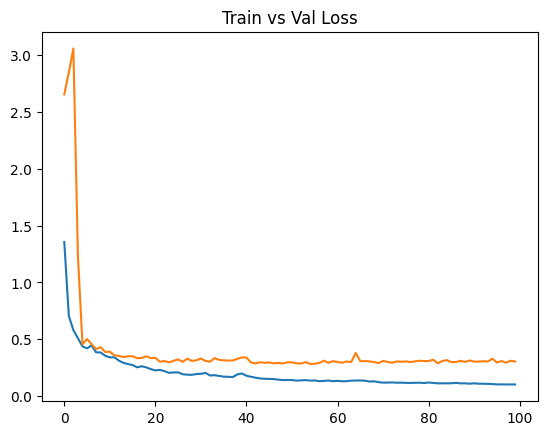

In [19]:
plt.title('Train vs Val Loss')
plt.plot(loss_lst)
plt.plot(val_loss_lst)

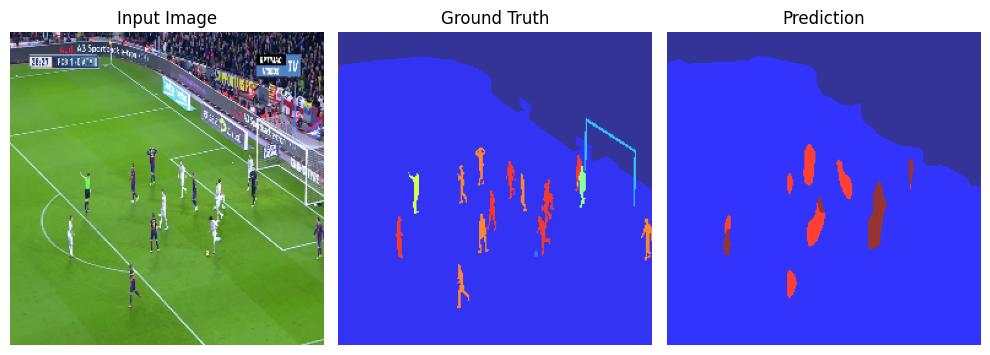

In [20]:
images, masks = next(iter(test_loader))
images, masks = images.to(device), masks.to(device)

# Predict
model.eval()
with torch.no_grad():
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)

# Move to CPU for visualization
images = images.cpu()
masks = masks.cpu()
preds = preds.cpu()
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Original image
axs[0].imshow(images.squeeze().permute(1, 2, 0), cmap='gray')
axs[0].set_title('Input Image')
axs[0].axis('off')

# Ground truth mask
axs[1].imshow(masks.squeeze(), cmap='jet', alpha=0.8)
axs[1].set_title('Ground Truth')
axs[1].axis('off')

# Predicted mask
axs[2].imshow(preds[0], cmap='jet', alpha=0.8)
axs[2].set_title('Prediction')
axs[2].axis('off')

plt.tight_layout()
plt.show()

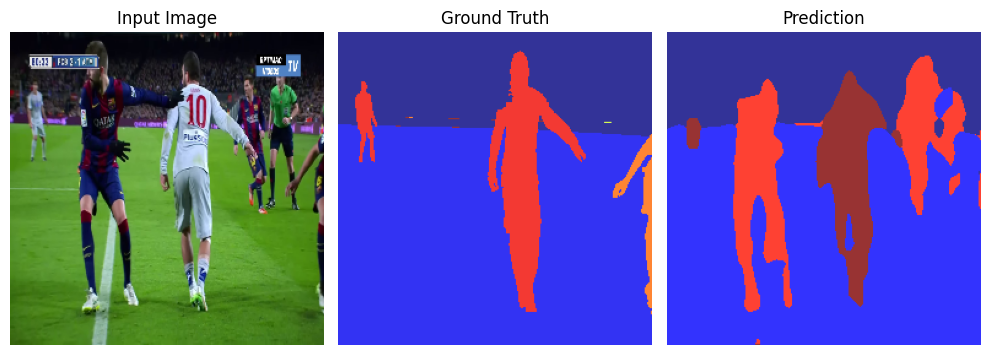

In [21]:
images, masks = next(iter(test_loader))
images, masks = images.to(device), masks.to(device)

# Predict
model.eval()
with torch.no_grad():
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)

# Move to CPU for visualization
images = images.cpu()
masks = masks.cpu()
preds = preds.cpu()
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Original image
axs[0].imshow(images.squeeze().permute(1, 2, 0), cmap='gray')
axs[0].set_title('Input Image')
axs[0].axis('off')

# Ground truth mask
axs[1].imshow(masks.squeeze(), cmap='jet', alpha=0.8)
axs[1].set_title('Ground Truth')
axs[1].axis('off')

# Predicted mask
axs[2].imshow(preds[0], cmap='jet', alpha=0.8)
axs[2].set_title('Prediction')
axs[2].axis('off')

plt.tight_layout()
plt.show()

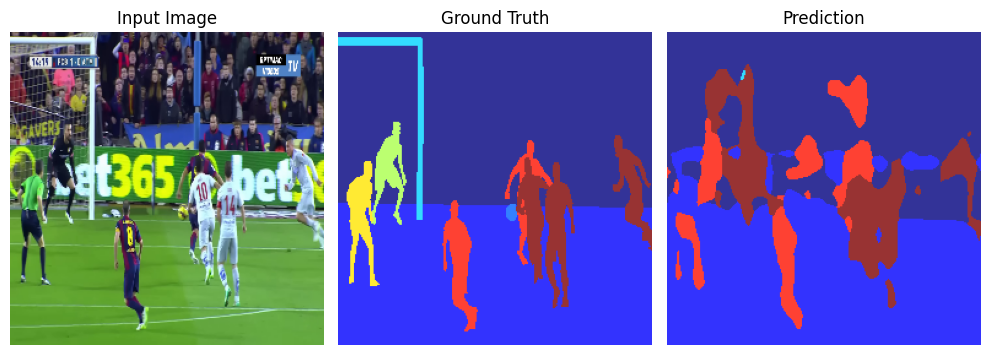

In [22]:
images, masks = next(iter(test_loader))
images, masks = images.to(device), masks.to(device)

# Predict
model.eval()
with torch.no_grad():
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)

# Move to CPU for visualization
images = images.cpu()
masks = masks.cpu()
preds = preds.cpu()
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Original image
axs[0].imshow(images.squeeze().permute(1, 2, 0), cmap='gray')
axs[0].set_title('Input Image')
axs[0].axis('off')

# Ground truth mask
axs[1].imshow(masks.squeeze(), cmap='jet', alpha=0.8)
axs[1].set_title('Ground Truth')
axs[1].axis('off')

# Predicted mask
axs[2].imshow(preds[0], cmap='jet', alpha=0.8)
axs[2].set_title('Prediction')
axs[2].axis('off')

plt.tight_layout()
plt.show()

## FCN + Original Structure + SGD + Bilear Upsample

In [23]:
# --- START FIX: Corrected and Improved Training Loop ---
model = FCN8s_bilinear(3,11).to(device)

epochs = 100
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
# FIX 2: Add a learning rate scheduler
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1, verbose=True)

loss_lst = []
val_loss_lst = [] # Track validation loss

for epoch in range(1, epochs + 1):
    total_loss = 0
    model.train() # Set model to training mode
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        
        pred = model(x)
        loss = loss_fn(pred,y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # FIX 3: Correct average loss calculation
    epoch_loss = total_loss / len(train_loader)
    loss_lst.append(epoch_loss)
    
    # --- Calculate Validation Loss (Good practice and needed for scheduler) ---
    model.eval() # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for x_val, y_val in test_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            val_pred = model(x_val)
            val_loss = loss_fn(val_pred, y_val)
            total_val_loss += val_loss.item()
            
    epoch_val_loss = total_val_loss / len(test_loader)
    val_loss_lst.append(epoch_val_loss)
    
    # Print both losses
    print(f"Epoch [{epoch}/{epochs}] Train Loss: {epoch_loss:.4f}  Val Loss: {epoch_val_loss:.4f}")
    
    # Step the scheduler based on validation loss
    # scheduler.step(epoch_val_loss)

# Save the new, improved model
torch.save(model.state_dict(), "FCN8s_Bilinear_SGD.pth")
# --- END FIX ---

Epoch [1/100] Train Loss: 1.9167  Val Loss: 1.9287
Epoch [2/100] Train Loss: 0.9620  Val Loss: 1.6629
Epoch [3/100] Train Loss: 0.7424  Val Loss: 1.9611
Epoch [4/100] Train Loss: 0.7128  Val Loss: 1.4865
Epoch [5/100] Train Loss: 0.6473  Val Loss: 0.7526
Epoch [6/100] Train Loss: 0.6081  Val Loss: 0.6276
Epoch [7/100] Train Loss: 0.6433  Val Loss: 0.5753
Epoch [8/100] Train Loss: 0.5818  Val Loss: 0.5442
Epoch [9/100] Train Loss: 0.5923  Val Loss: 0.5213
Epoch [10/100] Train Loss: 0.5694  Val Loss: 0.4990
Epoch [11/100] Train Loss: 0.5448  Val Loss: 0.4888
Epoch [12/100] Train Loss: 0.5140  Val Loss: 0.4783
Epoch [13/100] Train Loss: 0.5026  Val Loss: 0.4980
Epoch [14/100] Train Loss: 0.4846  Val Loss: 0.4623
Epoch [15/100] Train Loss: 0.4716  Val Loss: 0.4507
Epoch [16/100] Train Loss: 0.4520  Val Loss: 0.4405
Epoch [17/100] Train Loss: 0.4409  Val Loss: 0.4334
Epoch [18/100] Train Loss: 0.4259  Val Loss: 0.5078
Epoch [19/100] Train Loss: 0.4190  Val Loss: 0.4276
Epoch [20/100] Train 

In [24]:
num_classes = 11  # number of segmentation classes

total_miou, total_acc, count = 0, 0, 0

model.eval()
with torch.no_grad():
    for image, label in test_loader:
        image, label = image.to(device), label.to(device)
        output = model(image)
        preds = torch.argmax(output, dim=1)

        miou, acc = segmentation_metrics(output, label, num_classes=11)
        # print(f"Mean IoU: {miou:.4f}, Pixel Accuracy: {acc:.4f}")
        total_miou += miou
        total_acc += acc
        count += 1
    print(total_miou / count, total_acc / count)


0.37850742696062817 0.8904861450195313


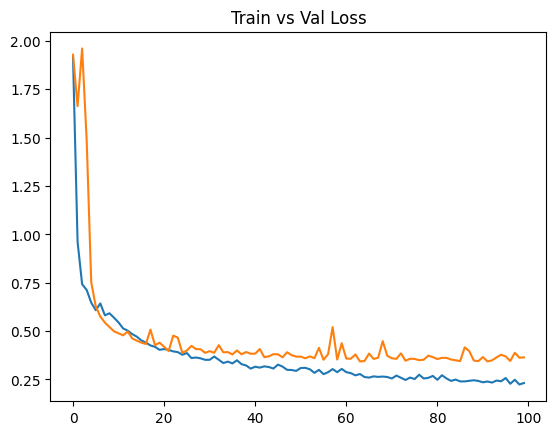

In [25]:
plt.title('Train vs Val Loss')
plt.plot(loss_lst)
plt.plot(val_loss_lst)

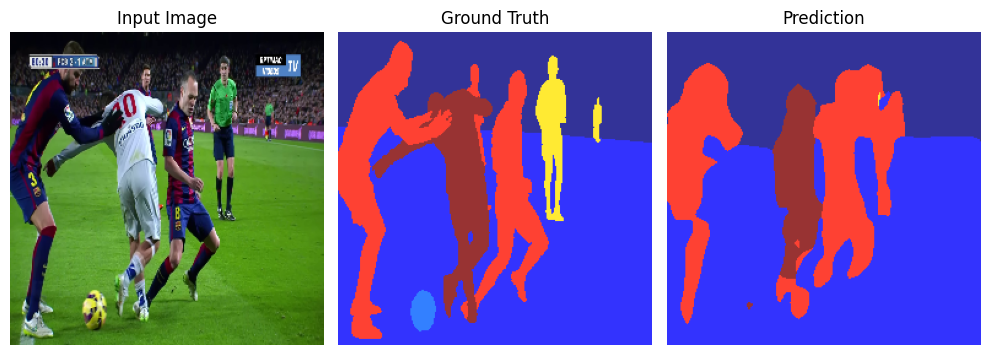

In [26]:
images, masks = next(iter(test_loader))
images, masks = images.to(device), masks.to(device)

# Predict
model.eval()
with torch.no_grad():
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)

# Move to CPU for visualization
images = images.cpu()
masks = masks.cpu()
preds = preds.cpu()
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Original image
axs[0].imshow(images.squeeze().permute(1, 2, 0), cmap='gray')
axs[0].set_title('Input Image')
axs[0].axis('off')

# Ground truth mask
axs[1].imshow(masks.squeeze(), cmap='jet', alpha=0.8)
axs[1].set_title('Ground Truth')
axs[1].axis('off')

# Predicted mask
axs[2].imshow(preds[0], cmap='jet', alpha=0.8)
axs[2].set_title('Prediction')
axs[2].axis('off')

plt.tight_layout()
plt.show()

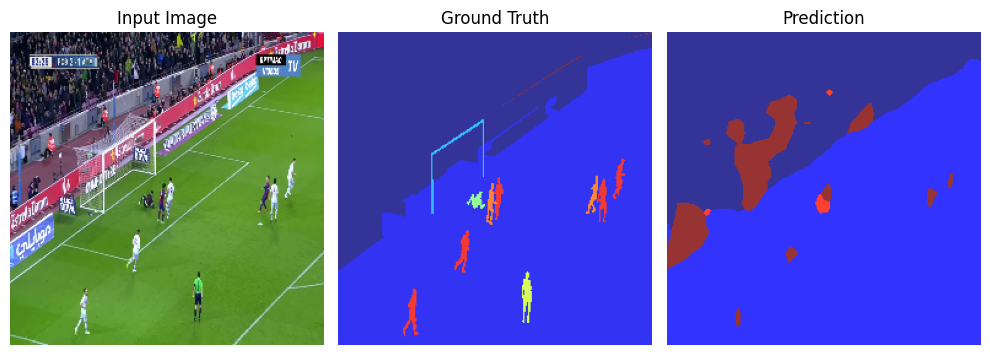

In [27]:
images, masks = next(iter(test_loader))
images, masks = images.to(device), masks.to(device)

# Predict
model.eval()
with torch.no_grad():
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)

# Move to CPU for visualization
images = images.cpu()
masks = masks.cpu()
preds = preds.cpu()
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Original image
axs[0].imshow(images.squeeze().permute(1, 2, 0), cmap='gray')
axs[0].set_title('Input Image')
axs[0].axis('off')

# Ground truth mask
axs[1].imshow(masks.squeeze(), cmap='jet', alpha=0.8)
axs[1].set_title('Ground Truth')
axs[1].axis('off')

# Predicted mask
axs[2].imshow(preds[0], cmap='jet', alpha=0.8)
axs[2].set_title('Prediction')
axs[2].axis('off')

plt.tight_layout()
plt.show()

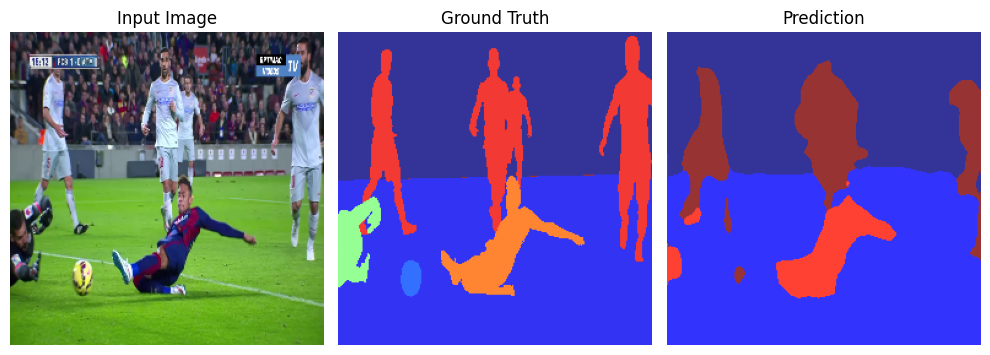

In [28]:
images, masks = next(iter(test_loader))
images, masks = images.to(device), masks.to(device)

# Predict
model.eval()
with torch.no_grad():
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)

# Move to CPU for visualization
images = images.cpu()
masks = masks.cpu()
preds = preds.cpu()
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Original image
axs[0].imshow(images.squeeze().permute(1, 2, 0), cmap='gray')
axs[0].set_title('Input Image')
axs[0].axis('off')

# Ground truth mask
axs[1].imshow(masks.squeeze(), cmap='jet', alpha=0.8)
axs[1].set_title('Ground Truth')
axs[1].axis('off')

# Predicted mask
axs[2].imshow(preds[0], cmap='jet', alpha=0.8)
axs[2].set_title('Prediction')
axs[2].axis('off')

plt.tight_layout()
plt.show()

### This is MiniResNet Backbone Experiment

In [13]:
class ConvBlock(nn.Module):
    def __init__(self,c_in,kernel,stride,padding) :
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(c_in,c_in,kernel,stride,padding,bias=False),
            nn.BatchNorm2d(c_in),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(c_in,c_in,kernel,stride,padding,bias=False),
            nn.BatchNorm2d(c_in), 
        )

    def forward(self,x):
        out = self.conv1(x)
        out = F.relu(self.conv2(x) + x)
        return out

In [14]:
class DownBlock(nn.Module):
    def __init__(self,c_in,c_out,kernel,stride,padding) :
        super().__init__()
        
        self.downconv = nn.Sequential(
            nn.Conv2d(c_in,c_out,kernel,2,padding,bias=False),
            nn.BatchNorm2d(c_out),
            nn.ReLU()
        )  
        self.conv2 = nn.Sequential(
            nn.Conv2d(c_out,c_out,kernel,stride,padding,bias=False),
            nn.BatchNorm2d(c_out),
            nn.ReLU()
        )
    
    def forward(self,x):
        out = F.relu(self.conv2(self.downconv(x)) + self.downconv(x))
        return out

In [67]:
class MiniResNet(nn.Module):
    def __init__(self,c_in,n_class,unit= [8, 16, 32, 64, 512]) :
        super().__init__()
        ######### BackBone MiniResNet ########
        self.preBlock = nn.Conv2d(c_in,unit[0],kernel_size=3,stride=1,padding=1)
        self.block1 = nn.Sequential(
                    # --- Original Blocks ---
                    ConvBlock(unit[0],3,1,1),
                    ConvBlock(unit[0],3,1,1),
            
                )
        self.block2 = nn.Sequential(
                    DownBlock(unit[0],unit[1],3,1,1), 
                    ConvBlock(unit[1],3,1,1),
        )
        self.block3 = nn.Sequential(
                    DownBlock(unit[1],unit[2],3,1,1), 
                    ConvBlock(unit[2],3,1,1),
        )
        self.block4 = nn.Sequential(
                    DownBlock(unit[2],unit[3],3,1,1), 
                    ConvBlock(unit[3],3,1,1),
        )
        self.block5 = nn.Sequential(
                    DownBlock(unit[3],unit[3],3,1,1), 
                    ConvBlock(unit[3],3,1,1),
        )
        self.block6 = nn.Sequential(
                    DownBlock(unit[3],unit[3],3,1,1), 
                    ConvBlock(unit[3],3,1,1),
                    nn.Conv2d(unit[3],n_class,1,1,0,bias=False)
        )
        ###### Upsample Original #######
        self.block7 = nn.Sequential(
            nn.ConvTranspose2d(n_class,n_class,kernel_size=4,stride=2,padding=1,output_padding=0,bias=False),
            nn.BatchNorm2d(n_class),
            nn.ReLU(),  
        )
        self.block8 = nn.Sequential(
            nn.ConvTranspose2d(n_class,n_class,kernel_size=4,stride=2,padding=1,output_padding=0,bias=False),
            nn.BatchNorm2d(n_class),
            nn.ReLU(),  
        )

        self.block9 = nn.Sequential(
            nn.ConvTranspose2d(n_class,n_class, kernel_size=8, stride=8, padding=0,bias=False),
            nn.Conv2d(n_class,n_class,kernel_size=1,stride=1,bias=False),
        )

        self.skipblock1 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(unit[2],n_class,kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(n_class),
            nn.ReLU(), 
        )
        self.skipblock2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(unit[3],n_class,kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(n_class),
            nn.ReLU(), 
        )
        
    def forward(self,x):
        x = self.preBlock(x)
        x = self.block1(x) # 256
        x = self.block2(x) # 128
        x = self.block3(x) # 64
        skip1 = self.skipblock1(x)
        x = self.block4(x) # 32
        skip2 = self.skipblock2(x)
        x = self.block5(x) # 16
        x = self.block6(x) # 8
        x = self.block7(x) + skip2
        x = self.block8(x) + skip1
        x = self.block9(x)
        return x


In [68]:
model = MiniResNet(3,11).to('cuda')
summary(model,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 256, 256]             224
            Conv2d-2          [-1, 8, 256, 256]             576
       BatchNorm2d-3          [-1, 8, 256, 256]              16
              ReLU-4          [-1, 8, 256, 256]               0
            Conv2d-5          [-1, 8, 256, 256]             576
       BatchNorm2d-6          [-1, 8, 256, 256]              16
         ConvBlock-7          [-1, 8, 256, 256]               0
            Conv2d-8          [-1, 8, 256, 256]             576
       BatchNorm2d-9          [-1, 8, 256, 256]              16
             ReLU-10          [-1, 8, 256, 256]               0
           Conv2d-11          [-1, 8, 256, 256]             576
      BatchNorm2d-12          [-1, 8, 256, 256]              16
        ConvBlock-13          [-1, 8, 256, 256]               0
           Conv2d-14         [-1, 16, 1

### FCN8s with MiniResNet BackBone + Adam + Conv2dTranspose (Upsize)

In [71]:
# --- START FIX: Corrected and Improved Training Loop ---
model = MiniResNet(3,11).to(device)

epochs = 100
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# FIX 2: Add a learning rate scheduler
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1, verbose=True)

loss_lst = []
val_loss_lst = [] # Track validation loss

for epoch in range(1, epochs + 1):
    total_loss = 0
    model.train() # Set model to training mode
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        
        pred = model(x)
        loss = loss_fn(pred,y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # FIX 3: Correct average loss calculation
    epoch_loss = total_loss / len(train_loader)
    loss_lst.append(epoch_loss)
    
    # --- Calculate Validation Loss (Good practice and needed for scheduler) ---
    model.eval() # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for x_val, y_val in test_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            val_pred = model(x_val)
            val_loss = loss_fn(val_pred, y_val)
            total_val_loss += val_loss.item()
            
    epoch_val_loss = total_val_loss / len(test_loader)
    val_loss_lst.append(epoch_val_loss)
    
    # Print both losses
    print(f"Epoch [{epoch}/{epochs}] Train Loss: {epoch_loss:.4f}  Val Loss: {epoch_val_loss:.4f}")
    
    # Step the scheduler based on validation loss
    # scheduler.step(epoch_val_loss)

# Save the new, improved model
torch.save(model.state_dict(), "FCN8s_MiniResNet_SGD.pth")
# --- END FIX ---

Epoch [1/100] Train Loss: 2.3295  Val Loss: 2.3653
Epoch [2/100] Train Loss: 2.1346  Val Loss: 2.1662
Epoch [3/100] Train Loss: 1.8961  Val Loss: 1.7816
Epoch [4/100] Train Loss: 1.6157  Val Loss: 1.4004
Epoch [5/100] Train Loss: 1.3652  Val Loss: 1.1189
Epoch [6/100] Train Loss: 1.1317  Val Loss: 1.0527
Epoch [7/100] Train Loss: 0.9354  Val Loss: 0.7594
Epoch [8/100] Train Loss: 0.8215  Val Loss: 0.7105
Epoch [9/100] Train Loss: 0.7097  Val Loss: 0.8465
Epoch [10/100] Train Loss: 0.6631  Val Loss: 0.6150
Epoch [11/100] Train Loss: 0.6181  Val Loss: 0.5724
Epoch [12/100] Train Loss: 0.5971  Val Loss: 0.5625
Epoch [13/100] Train Loss: 0.5789  Val Loss: 0.5264
Epoch [14/100] Train Loss: 0.5498  Val Loss: 0.4969
Epoch [15/100] Train Loss: 0.5477  Val Loss: 0.4812
Epoch [16/100] Train Loss: 0.5331  Val Loss: 0.4807
Epoch [17/100] Train Loss: 0.5513  Val Loss: 0.5286
Epoch [18/100] Train Loss: 0.5234  Val Loss: 0.4854
Epoch [19/100] Train Loss: 0.5040  Val Loss: 0.4672
Epoch [20/100] Train 

In [72]:
num_classes = 11  # number of segmentation classes

total_miou, total_acc, count = 0, 0, 0

model.eval()
with torch.no_grad():
    for image, label in test_loader:
        image, label = image.to(device), label.to(device)
        output = model(image)
        preds = torch.argmax(output, dim=1)

        miou, acc = segmentation_metrics(output, label, num_classes=11)
        # print(f"Mean IoU: {miou:.4f}, Pixel Accuracy: {acc:.4f}")
        total_miou += miou
        total_acc += acc
        count += 1
    print(total_miou / count, total_acc / count)


0.43382637644636324 0.9250160217285156


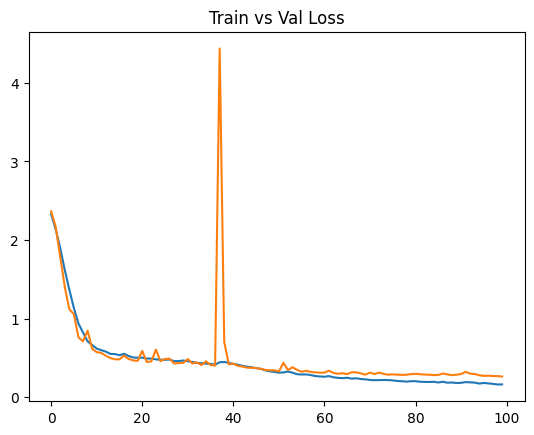

In [73]:
plt.title('Train vs Val Loss')
plt.plot(loss_lst)
plt.plot(val_loss_lst)

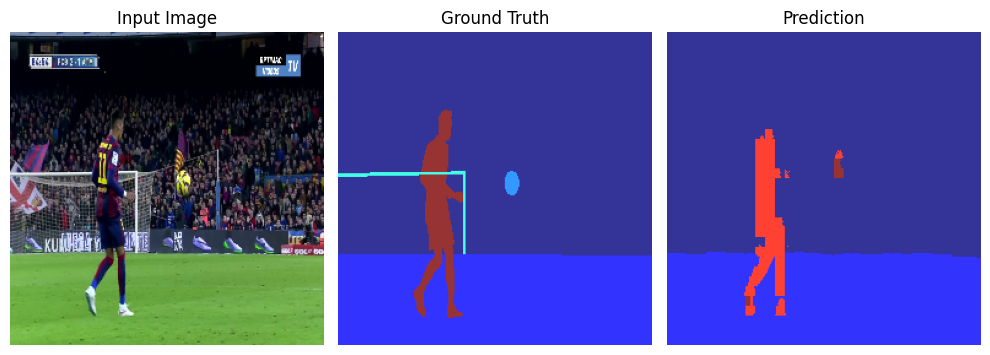

In [74]:
images, masks = next(iter(test_loader))
images, masks = images.to(device), masks.to(device)

# Predict
model.eval()
with torch.no_grad():
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)

# Move to CPU for visualization
images = images.cpu()
masks = masks.cpu()
preds = preds.cpu()
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Original image
axs[0].imshow(images.squeeze().permute(1, 2, 0), cmap='gray')
axs[0].set_title('Input Image')
axs[0].axis('off')

# Ground truth mask
axs[1].imshow(masks.squeeze(), cmap='jet', alpha=0.8)
axs[1].set_title('Ground Truth')
axs[1].axis('off')

# Predicted mask
axs[2].imshow(preds[0], cmap='jet', alpha=0.8)
axs[2].set_title('Prediction')
axs[2].axis('off')

plt.tight_layout()
plt.show()

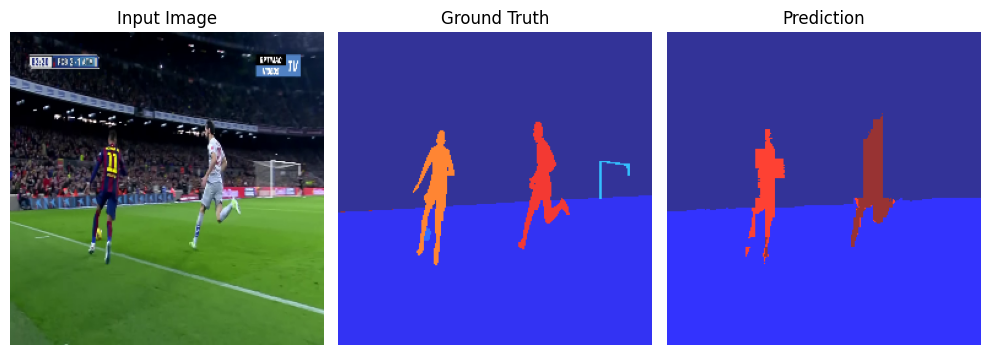

In [75]:
images, masks = next(iter(test_loader))
images, masks = images.to(device), masks.to(device)

# Predict
model.eval()
with torch.no_grad():
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)

# Move to CPU for visualization
images = images.cpu()
masks = masks.cpu()
preds = preds.cpu()
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Original image
axs[0].imshow(images.squeeze().permute(1, 2, 0), cmap='gray')
axs[0].set_title('Input Image')
axs[0].axis('off')

# Ground truth mask
axs[1].imshow(masks.squeeze(), cmap='jet', alpha=0.8)
axs[1].set_title('Ground Truth')
axs[1].axis('off')

# Predicted mask
axs[2].imshow(preds[0], cmap='jet', alpha=0.8)
axs[2].set_title('Prediction')
axs[2].axis('off')

plt.tight_layout()
plt.show()

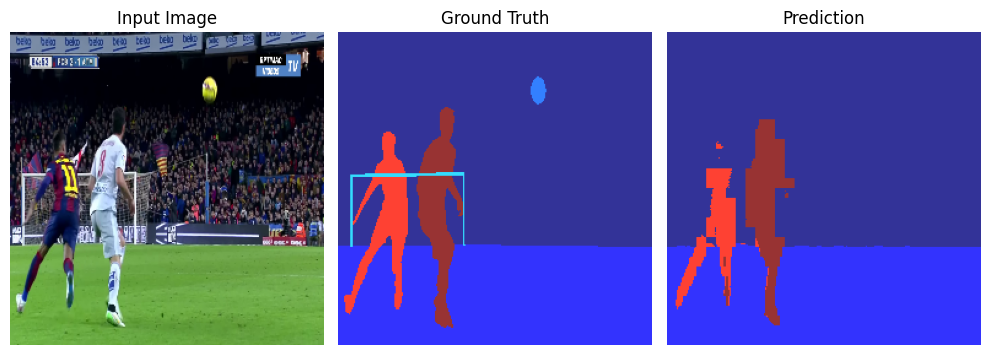

In [76]:
images, masks = next(iter(test_loader))
images, masks = images.to(device), masks.to(device)

# Predict
model.eval()
with torch.no_grad():
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)

# Move to CPU for visualization
images = images.cpu()
masks = masks.cpu()
preds = preds.cpu()
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Original image
axs[0].imshow(images.squeeze().permute(1, 2, 0), cmap='gray')
axs[0].set_title('Input Image')
axs[0].axis('off')

# Ground truth mask
axs[1].imshow(masks.squeeze(), cmap='jet', alpha=0.8)
axs[1].set_title('Ground Truth')
axs[1].axis('off')

# Predicted mask
axs[2].imshow(preds[0], cmap='jet', alpha=0.8)
axs[2].set_title('Prediction')
axs[2].axis('off')

plt.tight_layout()
plt.show()

### FCN8s with BackBoner MiniResNet + SGD + Convtranspose

In [77]:
# --- START FIX: Corrected and Improved Training Loop ---
model = MiniResNet(3,11).to(device)

epochs = 100
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2,momentum=0.9)
# FIX 2: Add a learning rate scheduler
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1, verbose=True)

loss_lst = []
val_loss_lst = [] # Track validation loss

for epoch in range(1, epochs + 1):
    total_loss = 0
    model.train() # Set model to training mode
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        
        pred = model(x)
        loss = loss_fn(pred,y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # FIX 3: Correct average loss calculation
    epoch_loss = total_loss / len(train_loader)
    loss_lst.append(epoch_loss)
    
    # --- Calculate Validation Loss (Good practice and needed for scheduler) ---
    model.eval() # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for x_val, y_val in test_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            val_pred = model(x_val)
            val_loss = loss_fn(val_pred, y_val)
            total_val_loss += val_loss.item()
            
    epoch_val_loss = total_val_loss / len(test_loader)
    val_loss_lst.append(epoch_val_loss)
    
    # Print both losses
    print(f"Epoch [{epoch}/{epochs}] Train Loss: {epoch_loss:.4f}  Val Loss: {epoch_val_loss:.4f}")
    
    # Step the scheduler based on validation loss
    # scheduler.step(epoch_val_loss)

# Save the new, improved model
torch.save(model.state_dict(), "FCN8s_MiniResNet_SGD.pth")
# --- END FIX ---

Epoch [1/100] Train Loss: 2.3961  Val Loss: 2.3966
Epoch [2/100] Train Loss: 2.3904  Val Loss: 2.3939
Epoch [3/100] Train Loss: 2.3823  Val Loss: 2.3883
Epoch [4/100] Train Loss: 2.3723  Val Loss: 2.3780
Epoch [5/100] Train Loss: 2.3589  Val Loss: 2.3599
Epoch [6/100] Train Loss: 2.3415  Val Loss: 2.3285
Epoch [7/100] Train Loss: 2.3183  Val Loss: 2.2818
Epoch [8/100] Train Loss: 2.2870  Val Loss: 2.2283
Epoch [9/100] Train Loss: 2.2438  Val Loss: 2.1635
Epoch [10/100] Train Loss: 2.1807  Val Loss: 2.0796
Epoch [11/100] Train Loss: 2.0960  Val Loss: 1.9372
Epoch [12/100] Train Loss: 1.9846  Val Loss: 1.7581
Epoch [13/100] Train Loss: 1.8183  Val Loss: 1.4354
Epoch [14/100] Train Loss: 1.6090  Val Loss: 1.3287
Epoch [15/100] Train Loss: 1.3733  Val Loss: 1.1171
Epoch [16/100] Train Loss: 1.0872  Val Loss: 0.8448
Epoch [17/100] Train Loss: 0.8494  Val Loss: 0.7212
Epoch [18/100] Train Loss: 0.7448  Val Loss: 0.8673
Epoch [19/100] Train Loss: 0.6857  Val Loss: 0.7130
Epoch [20/100] Train 

In [78]:
num_classes = 11  # number of segmentation classes

total_miou, total_acc, count = 0, 0, 0

model.eval()
with torch.no_grad():
    for image, label in test_loader:
        image, label = image.to(device), label.to(device)
        output = model(image)
        preds = torch.argmax(output, dim=1)

        miou, acc = segmentation_metrics(output, label, num_classes=11)
        # print(f"Mean IoU: {miou:.4f}, Pixel Accuracy: {acc:.4f}")
        total_miou += miou
        total_acc += acc
        count += 1
    print(total_miou / count, total_acc / count)


0.31233071852289485 0.8795135498046875


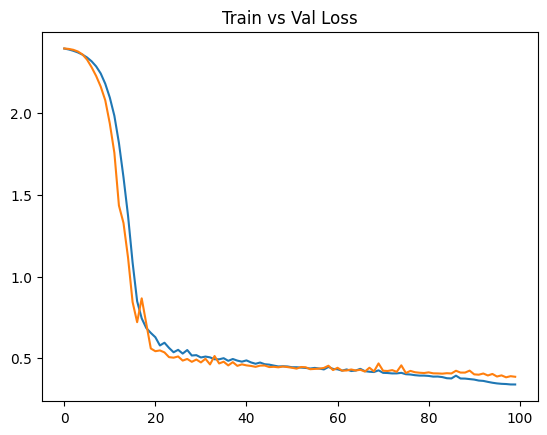

In [79]:
plt.title('Train vs Val Loss')
plt.plot(loss_lst)
plt.plot(val_loss_lst)

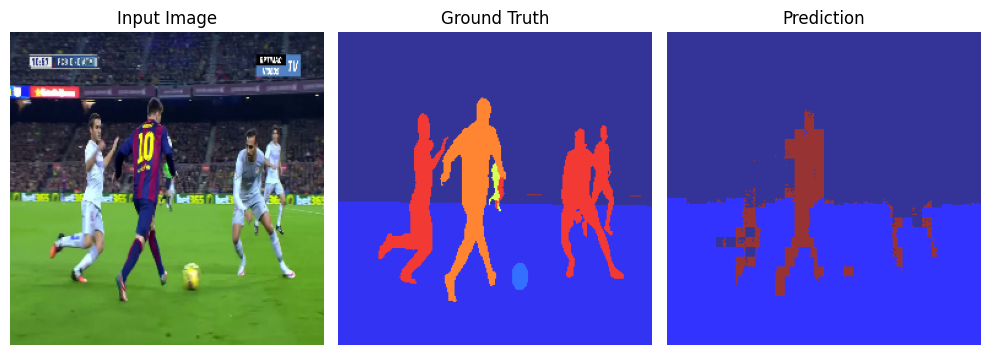

In [80]:
images, masks = next(iter(test_loader))
images, masks = images.to(device), masks.to(device)

# Predict
model.eval()
with torch.no_grad():
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)

# Move to CPU for visualization
images = images.cpu()
masks = masks.cpu()
preds = preds.cpu()
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Original image
axs[0].imshow(images.squeeze().permute(1, 2, 0), cmap='gray')
axs[0].set_title('Input Image')
axs[0].axis('off')

# Ground truth mask
axs[1].imshow(masks.squeeze(), cmap='jet', alpha=0.8)
axs[1].set_title('Ground Truth')
axs[1].axis('off')

# Predicted mask
axs[2].imshow(preds[0], cmap='jet', alpha=0.8)
axs[2].set_title('Prediction')
axs[2].axis('off')

plt.tight_layout()
plt.show()

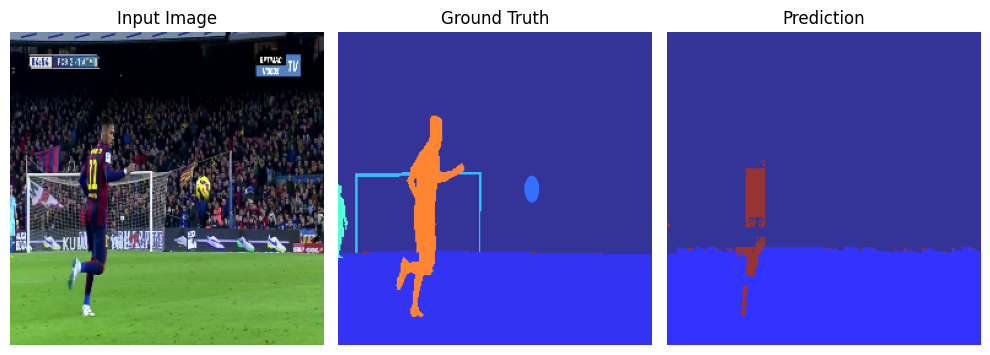

In [81]:
images, masks = next(iter(test_loader))
images, masks = images.to(device), masks.to(device)

# Predict
model.eval()
with torch.no_grad():
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)

# Move to CPU for visualization
images = images.cpu()
masks = masks.cpu()
preds = preds.cpu()
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Original image
axs[0].imshow(images.squeeze().permute(1, 2, 0), cmap='gray')
axs[0].set_title('Input Image')
axs[0].axis('off')

# Ground truth mask
axs[1].imshow(masks.squeeze(), cmap='jet', alpha=0.8)
axs[1].set_title('Ground Truth')
axs[1].axis('off')

# Predicted mask
axs[2].imshow(preds[0], cmap='jet', alpha=0.8)
axs[2].set_title('Prediction')
axs[2].axis('off')

plt.tight_layout()
plt.show()

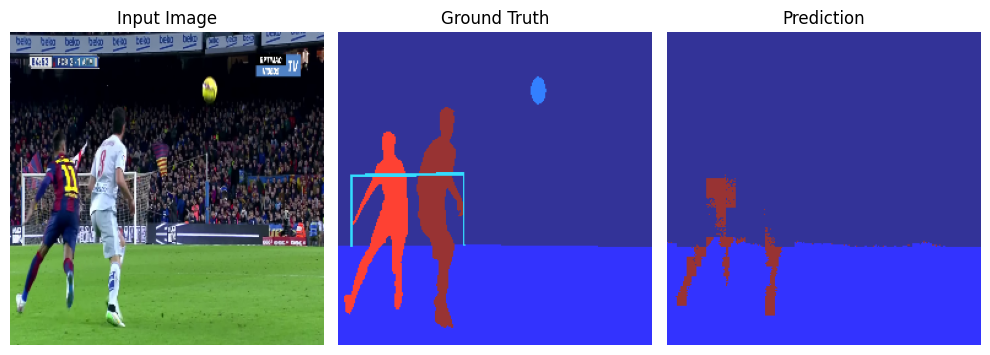

In [82]:
images, masks = next(iter(test_loader))
images, masks = images.to(device), masks.to(device)

# Predict
model.eval()
with torch.no_grad():
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)

# Move to CPU for visualization
images = images.cpu()
masks = masks.cpu()
preds = preds.cpu()
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Original image
axs[0].imshow(images.squeeze().permute(1, 2, 0), cmap='gray')
axs[0].set_title('Input Image')
axs[0].axis('off')

# Ground truth mask
axs[1].imshow(masks.squeeze(), cmap='jet', alpha=0.8)
axs[1].set_title('Ground Truth')
axs[1].axis('off')

# Predicted mask
axs[2].imshow(preds[0], cmap='jet', alpha=0.8)
axs[2].set_title('Prediction')
axs[2].axis('off')

plt.tight_layout()
plt.show()

In [11]:
class MiniResNetBilinear(nn.Module):
    def __init__(self,c_in,n_class,unit= [8, 16, 32, 64, 512]) :
        super().__init__()
        ######### BackBone MiniResNet ########
        self.preBlock = nn.Conv2d(c_in,unit[0],kernel_size=3,stride=1,padding=1)
        self.block1 = nn.Sequential(
                    # --- Original Blocks ---
                    ConvBlock(unit[0],3,1,1),
                    ConvBlock(unit[0],3,1,1),
            
                )
        self.block2 = nn.Sequential(
                    DownBlock(unit[0],unit[1],3,1,1), 
                    ConvBlock(unit[1],3,1,1),
        )
        self.block3 = nn.Sequential(
                    DownBlock(unit[1],unit[2],3,1,1), 
                    ConvBlock(unit[2],3,1,1),
        )
        self.block4 = nn.Sequential(
                    DownBlock(unit[2],unit[3],3,1,1), 
                    ConvBlock(unit[3],3,1,1),
        )
        self.block5 = nn.Sequential(
                    DownBlock(unit[3],unit[3],3,1,1), 
                    ConvBlock(unit[3],3,1,1),
        )
        self.block6 = nn.Sequential(
                    DownBlock(unit[3],unit[3],3,1,1), 
                    ConvBlock(unit[3],3,1,1),
                    nn.Conv2d(unit[3],n_class,1,1,0,bias=False)
        )
        
        ###### Upsample with Bilinear #######
        self.block7 = nn.Sequential(
            # Replaced ConvTranspose2d with Upsample + Conv2d
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(n_class, n_class, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(n_class),
            nn.ReLU(),  
        )
        self.block8 = nn.Sequential(
            # Replaced ConvTranspose2d with Upsample + Conv2d
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(n_class, n_class, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(n_class),
            nn.ReLU(),  
        )

        self.block9 = nn.Sequential(
            # Replaced ConvTranspose2d with Upsample
            nn.Upsample(scale_factor=8, mode='bilinear', align_corners=False),
            nn.Conv2d(n_class,n_class,kernel_size=1,stride=1,bias=False),
        )
        
        # --- Skip blocks are unchanged ---
        self.skipblock1 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(unit[2],n_class,kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(n_class),
            nn.ReLU(), 
        )
        self.skipblock2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(unit[3],n_class,kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(n_class),
            nn.ReLU(), 
        )
        
    def forward(self,x):
        x = self.preBlock(x)
        x = self.block1(x) # 256
        x = self.block2(x) # 128
        x = self.block3(x) # 64
        skip1 = self.skipblock1(x)
        x = self.block4(x) # 32
        skip2 = self.skipblock2(x)
        x = self.block5(x) # 16
        x = self.block6(x) # 8
        x = self.block7(x) + skip2
        x = self.block8(x) + skip1
        x = self.block9(x)
        return x

In [15]:
summary(MiniResNetBilinear(3,11).to('cuda'),(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 256, 256]             224
            Conv2d-2          [-1, 8, 256, 256]             576
       BatchNorm2d-3          [-1, 8, 256, 256]              16
              ReLU-4          [-1, 8, 256, 256]               0
            Conv2d-5          [-1, 8, 256, 256]             576
       BatchNorm2d-6          [-1, 8, 256, 256]              16
         ConvBlock-7          [-1, 8, 256, 256]               0
            Conv2d-8          [-1, 8, 256, 256]             576
       BatchNorm2d-9          [-1, 8, 256, 256]              16
             ReLU-10          [-1, 8, 256, 256]               0
           Conv2d-11          [-1, 8, 256, 256]             576
      BatchNorm2d-12          [-1, 8, 256, 256]              16
        ConvBlock-13          [-1, 8, 256, 256]               0
           Conv2d-14         [-1, 16, 1

### FCN8s with MiniResNet BackBone + Adam + Bilinear

In [16]:
device = 'cuda:3'

In [17]:
# --- START FIX: Corrected and Improved Training Loop ---
model = MiniResNetBilinear(3,11).to(device)

epochs = 30
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# FIX 2: Add a learning rate scheduler
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1, verbose=True)

loss_lst = []
val_loss_lst = [] # Track validation loss

for epoch in range(1, epochs + 1):
    total_loss = 0
    model.train() # Set model to training mode
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        
        pred = model(x)
        loss = loss_fn(pred,y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # FIX 3: Correct average loss calculation
    epoch_loss = total_loss / len(train_loader)
    loss_lst.append(epoch_loss)
    
    # --- Calculate Validation Loss (Good practice and needed for scheduler) ---
    model.eval() # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for x_val, y_val in test_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            val_pred = model(x_val)
            val_loss = loss_fn(val_pred, y_val)
            total_val_loss += val_loss.item()
            
    epoch_val_loss = total_val_loss / len(test_loader)
    val_loss_lst.append(epoch_val_loss)
    
    # Print both losses
    print(f"Epoch [{epoch}/{epochs}] Train Loss: {epoch_loss:.4f}  Val Loss: {epoch_val_loss:.4f}")
    
    # Step the scheduler based on validation loss
    # scheduler.step(epoch_val_loss)

# Save the new, improved model
torch.save(model.state_dict(), "FCN8s_MiniResNet_bilinear_Adam.pth")
# --- END FIX ---

Epoch [1/30] Train Loss: 1.9450  Val Loss: 2.0930
Epoch [2/30] Train Loss: 1.5832  Val Loss: 1.5616
Epoch [3/30] Train Loss: 1.3807  Val Loss: 1.3678
Epoch [4/30] Train Loss: 1.2366  Val Loss: 1.1482
Epoch [5/30] Train Loss: 1.1225  Val Loss: 0.9798
Epoch [6/30] Train Loss: 1.0014  Val Loss: 1.0379
Epoch [7/30] Train Loss: 0.9321  Val Loss: 0.8607
Epoch [8/30] Train Loss: 0.8391  Val Loss: 0.8209
Epoch [9/30] Train Loss: 0.7832  Val Loss: 0.8610
Epoch [10/30] Train Loss: 0.6768  Val Loss: 0.6893
Epoch [11/30] Train Loss: 0.6299  Val Loss: 0.5997
Epoch [12/30] Train Loss: 0.5756  Val Loss: 0.5457
Epoch [13/30] Train Loss: 0.5905  Val Loss: 0.5201
Epoch [14/30] Train Loss: 0.5436  Val Loss: 0.6761
Epoch [15/30] Train Loss: 0.5014  Val Loss: 0.5002
Epoch [16/30] Train Loss: 0.4739  Val Loss: 0.4318
Epoch [17/30] Train Loss: 0.4440  Val Loss: 0.6998
Epoch [18/30] Train Loss: 0.4432  Val Loss: 0.4834
Epoch [19/30] Train Loss: 0.4127  Val Loss: 0.4101
Epoch [20/30] Train Loss: 0.3844  Val Lo

In [18]:
num_classes = 11  # number of segmentation classes

total_miou, total_acc, count = 0, 0, 0

model.eval()
with torch.no_grad():
    for image, label in test_loader:
        image, label = image.to(device), label.to(device)
        output = model(image)
        preds = torch.argmax(output, dim=1)

        miou, acc = segmentation_metrics(output, label, num_classes=11)
        # print(f"Mean IoU: {miou:.4f}, Pixel Accuracy: {acc:.4f}")
        total_miou += miou
        total_acc += acc
        count += 1
    print(total_miou / count, total_acc / count)


0.42170864843789085 0.9209281921386718


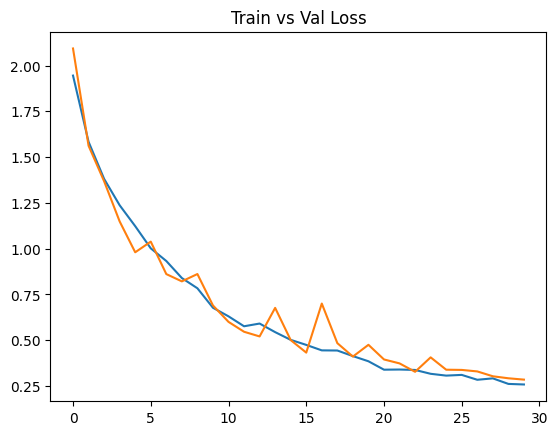

In [19]:
plt.title('Train vs Val Loss')
plt.plot(loss_lst)
plt.plot(val_loss_lst)

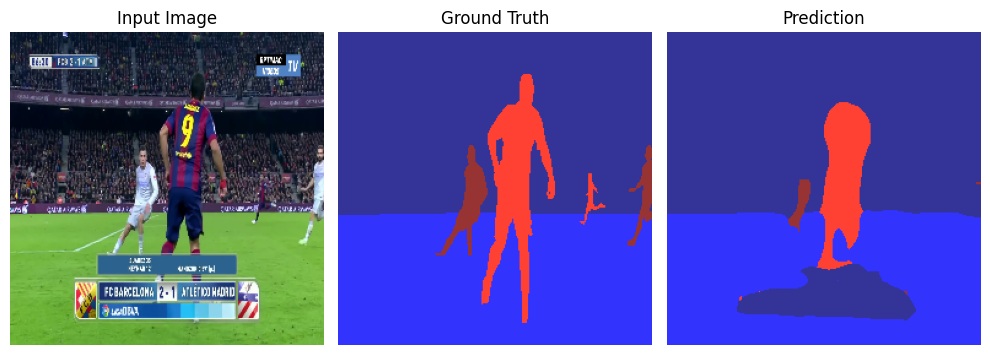

In [20]:
images, masks = next(iter(test_loader))
images, masks = images.to(device), masks.to(device)

# Predict
model.eval()
with torch.no_grad():
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)

# Move to CPU for visualization
images = images.cpu()
masks = masks.cpu()
preds = preds.cpu()
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Original image
axs[0].imshow(images.squeeze().permute(1, 2, 0), cmap='gray')
axs[0].set_title('Input Image')
axs[0].axis('off')

# Ground truth mask
axs[1].imshow(masks.squeeze(), cmap='jet', alpha=0.8)
axs[1].set_title('Ground Truth')
axs[1].axis('off')

# Predicted mask
axs[2].imshow(preds[0], cmap='jet', alpha=0.8)
axs[2].set_title('Prediction')
axs[2].axis('off')

plt.tight_layout()
plt.show()

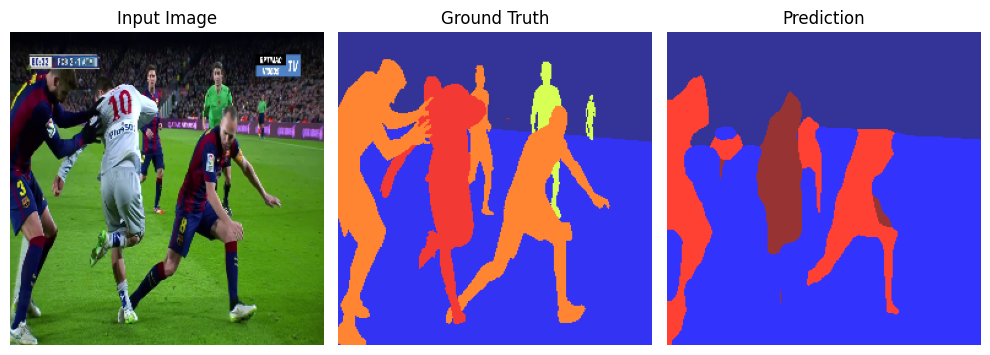

In [21]:
images, masks = next(iter(test_loader))
images, masks = images.to(device), masks.to(device)

# Predict
model.eval()
with torch.no_grad():
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)

# Move to CPU for visualization
images = images.cpu()
masks = masks.cpu()
preds = preds.cpu()
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Original image
axs[0].imshow(images.squeeze().permute(1, 2, 0), cmap='gray')
axs[0].set_title('Input Image')
axs[0].axis('off')

# Ground truth mask
axs[1].imshow(masks.squeeze(), cmap='jet', alpha=0.8)
axs[1].set_title('Ground Truth')
axs[1].axis('off')

# Predicted mask
axs[2].imshow(preds[0], cmap='jet', alpha=0.8)
axs[2].set_title('Prediction')
axs[2].axis('off')

plt.tight_layout()
plt.show()

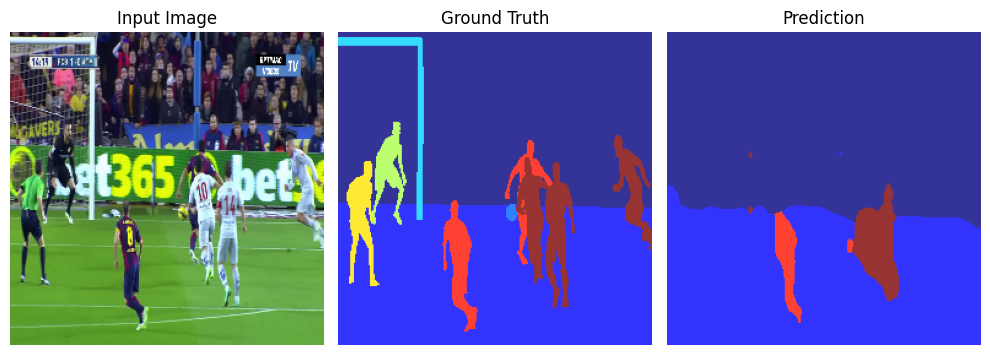

In [22]:
images, masks = next(iter(test_loader))
images, masks = images.to(device), masks.to(device)

# Predict
model.eval()
with torch.no_grad():
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)

# Move to CPU for visualization
images = images.cpu()
masks = masks.cpu()
preds = preds.cpu()
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Original image
axs[0].imshow(images.squeeze().permute(1, 2, 0), cmap='gray')
axs[0].set_title('Input Image')
axs[0].axis('off')

# Ground truth mask
axs[1].imshow(masks.squeeze(), cmap='jet', alpha=0.8)
axs[1].set_title('Ground Truth')
axs[1].axis('off')

# Predicted mask
axs[2].imshow(preds[0], cmap='jet', alpha=0.8)
axs[2].set_title('Prediction')
axs[2].axis('off')

plt.tight_layout()
plt.show()

### FCN8s with MiniResNet BackBone + SGD + Bilinear

In [23]:
# --- START FIX: Corrected and Improved Training Loop ---
model = MiniResNetBilinear(3,11).to(device)

epochs = 30
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2,momentum=0.9)
# FIX 2: Add a learning rate scheduler
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1, verbose=True)

loss_lst = []
val_loss_lst = [] # Track validation loss

for epoch in range(1, epochs + 1):
    total_loss = 0
    model.train() # Set model to training mode
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        
        pred = model(x)
        loss = loss_fn(pred,y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # FIX 3: Correct average loss calculation
    epoch_loss = total_loss / len(train_loader)
    loss_lst.append(epoch_loss)
    
    # --- Calculate Validation Loss (Good practice and needed for scheduler) ---
    model.eval() # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for x_val, y_val in test_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            val_pred = model(x_val)
            val_loss = loss_fn(val_pred, y_val)
            total_val_loss += val_loss.item()
            
    epoch_val_loss = total_val_loss / len(test_loader)
    val_loss_lst.append(epoch_val_loss)
    
    # Print both losses
    print(f"Epoch [{epoch}/{epochs}] Train Loss: {epoch_loss:.4f}  Val Loss: {epoch_val_loss:.4f}")
    
    # Step the scheduler based on validation loss
    # scheduler.step(epoch_val_loss)

# Save the new, improved model
torch.save(model.state_dict(), "FCN8s_MiniResNet_bilinear_SGD.pth")
# --- END FIX ---

Epoch [1/30] Train Loss: 1.7705  Val Loss: 2.0588
Epoch [2/30] Train Loss: 0.8329  Val Loss: 1.7152
Epoch [3/30] Train Loss: 0.5863  Val Loss: 0.6269
Epoch [4/30] Train Loss: 0.5209  Val Loss: 0.4964
Epoch [5/30] Train Loss: 0.4588  Val Loss: 0.4875
Epoch [6/30] Train Loss: 0.4207  Val Loss: 0.4084
Epoch [7/30] Train Loss: 0.3880  Val Loss: 0.3655
Epoch [8/30] Train Loss: 0.3884  Val Loss: 0.3844
Epoch [9/30] Train Loss: 0.3461  Val Loss: 0.3736
Epoch [10/30] Train Loss: 0.3325  Val Loss: 0.3145
Epoch [11/30] Train Loss: 0.3470  Val Loss: 0.4204
Epoch [12/30] Train Loss: 0.3292  Val Loss: 0.3143
Epoch [13/30] Train Loss: 0.3036  Val Loss: 0.3076
Epoch [14/30] Train Loss: 0.2773  Val Loss: 0.3401
Epoch [15/30] Train Loss: 0.2909  Val Loss: 0.3073
Epoch [16/30] Train Loss: 0.2712  Val Loss: 0.3571
Epoch [17/30] Train Loss: 0.2874  Val Loss: 0.3020
Epoch [18/30] Train Loss: 0.2600  Val Loss: 0.3395
Epoch [19/30] Train Loss: 0.2528  Val Loss: 0.3099
Epoch [20/30] Train Loss: 0.2467  Val Lo

In [24]:
num_classes = 11  # number of segmentation classes

total_miou, total_acc, count = 0, 0, 0

model.eval()
with torch.no_grad():
    for image, label in test_loader:
        image, label = image.to(device), label.to(device)
        output = model(image)
        preds = torch.argmax(output, dim=1)

        miou, acc = segmentation_metrics(output, label, num_classes=11)
        # print(f"Mean IoU: {miou:.4f}, Pixel Accuracy: {acc:.4f}")
        total_miou += miou
        total_acc += acc
        count += 1
    print(total_miou / count, total_acc / count)


0.41835426430795175 0.9167701721191406


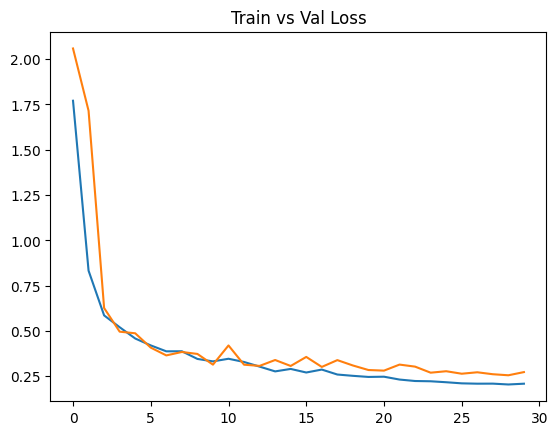

In [25]:
plt.title('Train vs Val Loss')
plt.plot(loss_lst)
plt.plot(val_loss_lst)

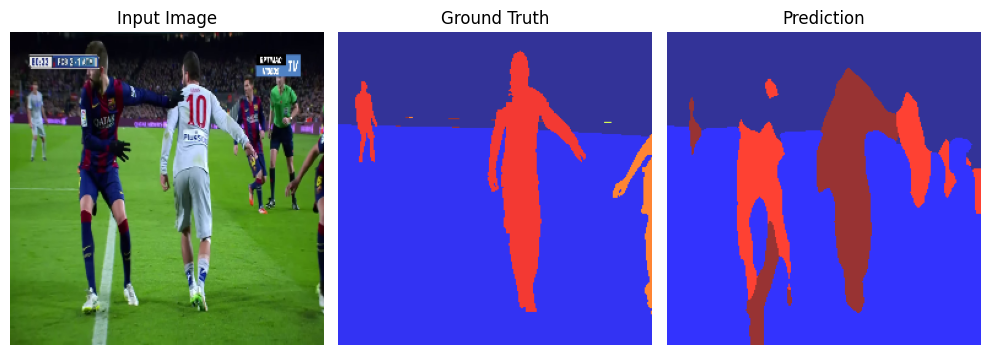

In [26]:
images, masks = next(iter(test_loader))
images, masks = images.to(device), masks.to(device)

# Predict
model.eval()
with torch.no_grad():
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)

# Move to CPU for visualization
images = images.cpu()
masks = masks.cpu()
preds = preds.cpu()
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Original image
axs[0].imshow(images.squeeze().permute(1, 2, 0), cmap='gray')
axs[0].set_title('Input Image')
axs[0].axis('off')

# Ground truth mask
axs[1].imshow(masks.squeeze(), cmap='jet', alpha=0.8)
axs[1].set_title('Ground Truth')
axs[1].axis('off')

# Predicted mask
axs[2].imshow(preds[0], cmap='jet', alpha=0.8)
axs[2].set_title('Prediction')
axs[2].axis('off')

plt.tight_layout()
plt.show()

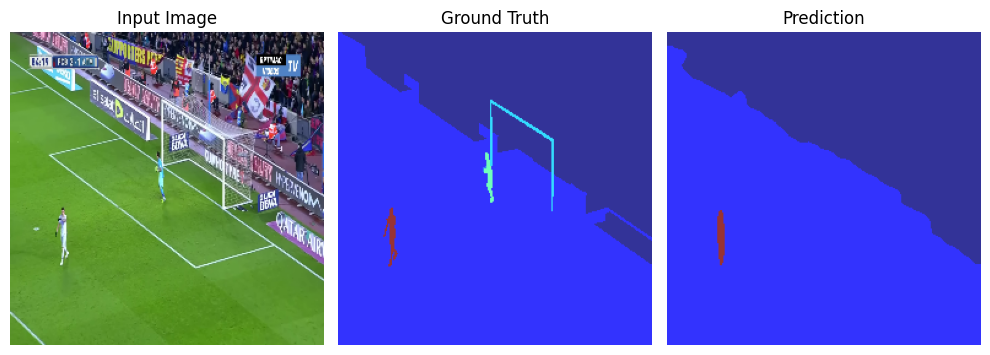

In [27]:
images, masks = next(iter(test_loader))
images, masks = images.to(device), masks.to(device)

# Predict
model.eval()
with torch.no_grad():
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)

# Move to CPU for visualization
images = images.cpu()
masks = masks.cpu()
preds = preds.cpu()
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Original image
axs[0].imshow(images.squeeze().permute(1, 2, 0), cmap='gray')
axs[0].set_title('Input Image')
axs[0].axis('off')

# Ground truth mask
axs[1].imshow(masks.squeeze(), cmap='jet', alpha=0.8)
axs[1].set_title('Ground Truth')
axs[1].axis('off')

# Predicted mask
axs[2].imshow(preds[0], cmap='jet', alpha=0.8)
axs[2].set_title('Prediction')
axs[2].axis('off')

plt.tight_layout()
plt.show()

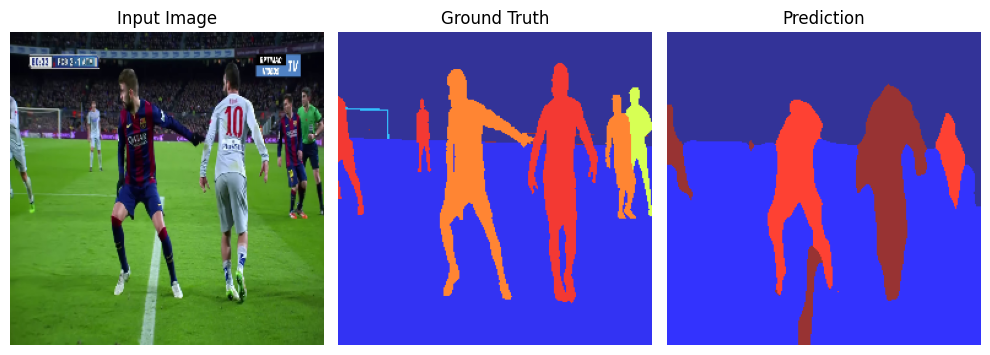

In [28]:
images, masks = next(iter(test_loader))
images, masks = images.to(device), masks.to(device)

# Predict
model.eval()
with torch.no_grad():
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)

# Move to CPU for visualization
images = images.cpu()
masks = masks.cpu()
preds = preds.cpu()
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Original image
axs[0].imshow(images.squeeze().permute(1, 2, 0), cmap='gray')
axs[0].set_title('Input Image')
axs[0].axis('off')

# Ground truth mask
axs[1].imshow(masks.squeeze(), cmap='jet', alpha=0.8)
axs[1].set_title('Ground Truth')
axs[1].axis('off')

# Predicted mask
axs[2].imshow(preds[0], cmap='jet', alpha=0.8)
axs[2].set_title('Prediction')
axs[2].axis('off')

plt.tight_layout()
plt.show()

| Model     | Iou Score | Pixel Accuracy Score |
|--------- |-----|---------|
| FCN8s with Original BackBone + Adam + ConvTranspose2D  | 0.44  | 0.92     |
| FCN8s with Original BackBone + SGD + ConvTranspose2D | 0.15  | 0.67  |
| FCN8s with Original BackBone + Adam + Bilinear | 0.4  | 0.9     |
| FCN8s with Original BackBone + SGD + Bilinear | 0.37  | 0.89 |
| FCN8s with MiniResNet BackBone + Adam + ConvTranspose2D | 0.43  | 0.92     |
| FCN8s with MiniResNet BackBone + SGD + ConvTranspose2D | 0.37  | 0.89  |
| FCN8s with MiniResNet BackBone + Adam + Bilinear | 0.42  | 0.92     |
| FCN8s with MiniResNet BackBone + SGD + Bilinear | 0.41  | 0.91  |



Pixel Accurcay Score so high because how Field class, and my model Bias for class Field. it may because of I train only 80 image so my model can not capture well.